In [2]:
!pip install nptdms scipy pymatreader -q
!pip install xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# For TDMS files
from nptdms import TdmsFile

# For MAT files
from scipy.io import loadmat
import scipy.signal as signal
from scipy.stats import kurtosis, skew, entropy
from scipy.fft import fft, fftfreq

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
from sklearn.decomposition import PCA

# Deep Learning (optional - for advanced model)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.7/131.7 MB 4.6 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.8/289.8 MB 7.2 MB/s eta 0:00:00m eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]━━━ 1/2 [xgboost]


2026-02-11 19:11:33.540969: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-11 19:11:33.989743: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-11 19:11:36.487386: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Libraries imported successfully!
TensorFlow version: 2.20.0


In [3]:
def extract_mat_data(file_path):
    """
    Extract vibration signal data from Test.Lab MAT file
    Handles nested Signal structure from LMS Test.Lab
    Returns: DataFrame with vibration channels (no timestamp needed for classification)
    """
    try:
        print(f"  Loading MAT file: {file_path.name}")
        mat_data = loadmat(file_path, struct_as_record=False, squeeze_me=False)
        
        # Check if Signal exists
        if 'Signal' not in mat_data:
            print(f"  Error: 'Signal' key not found in {file_path.name}")
            return None
        
        # Extract the Signal structure
        signal = mat_data['Signal'][0, 0]
        
        # Extract x_values (time information) - handle both mat_struct and array
        x_values = signal.x_values
        
        # Check if x_values is mat_struct or array
        if hasattr(x_values, 'start_value'):
            # It's a mat_struct
            start_time = float(x_values.start_value)
            time_increment = float(x_values.increment)
            num_samples = int(x_values.number_of_values)
        elif isinstance(x_values, np.ndarray) and x_values.shape == (1, 1):
            # It's a nested array
            x_vals = x_values[0, 0]
            start_time = float(x_vals.start_value)
            time_increment = float(x_vals.increment)
            num_samples = int(x_vals.number_of_values)
        else:
            print(f"  Error: Unexpected x_values structure")
            return None
        
        sampling_rate = 1 / time_increment
        duration = num_samples * time_increment
        
        print(f"  Samples: {num_samples:,}, Fs: {sampling_rate:.2f} Hz, Duration: {duration:.2f} s")
        
        # Extract y_values (actual vibration data)
        y_values = signal.y_values
        
        # Handle both mat_struct and nested array
        if hasattr(y_values, 'values'):
            values_field = y_values.values
        elif isinstance(y_values, np.ndarray) and y_values.shape == (1, 1):
            y_vals = y_values[0, 0]
            values_field = y_vals.values if hasattr(y_vals, 'values') else y_vals
        else:
            values_field = y_values
        
        # Navigate through nested structure to get actual data
        vibration_data = values_field
        
        # Unwrap nested structures
        max_iterations = 10  # Prevent infinite loops
        iteration = 0
        while iteration < max_iterations:
            iteration += 1
            
            if isinstance(vibration_data, np.ndarray):
                # Check if it's a numeric array
                if vibration_data.dtype.kind in ['f', 'i', 'u']:  # float, int, unsigned int
                    break
                
                # Check if it's object array with single element
                if vibration_data.dtype == np.object_ and vibration_data.size == 1:
                    vibration_data = vibration_data.item()
                    continue
                
                # Check if it's structured array
                if vibration_data.dtype.names is not None:
                    if 'values' in vibration_data.dtype.names:
                        vibration_data = vibration_data['values']
                    elif vibration_data.size == 1:
                        vibration_data = vibration_data[0, 0] if vibration_data.shape == (1, 1) else vibration_data[0]
                    else:
                        break
                    continue
                
                # Check if shape is (1, 1)
                if vibration_data.shape == (1, 1):
                    vibration_data = vibration_data[0, 0]
                    continue
                
                # If we reach here and it's numeric, we're done
                break
            
            # Check if it has 'values' attribute
            if hasattr(vibration_data, 'values'):
                vibration_data = vibration_data.values
                continue
            
            # If we can't process further, break
            break
        
        # Convert to numpy array if needed
        if not isinstance(vibration_data, np.ndarray):
            vibration_data = np.array(vibration_data)
        
        # Ensure 2D array (samples × channels)
        if vibration_data.ndim == 1:
            vibration_data = vibration_data.reshape(-1, 1)
        
        # Handle transposed data - if channels >> samples, transpose
        if vibration_data.shape[0] < vibration_data.shape[1]:
            print(f"  Transposing data from {vibration_data.shape} to ", end="")
            vibration_data = vibration_data.T
            print(f"{vibration_data.shape}")
        
        num_channels = vibration_data.shape[1]
        print(f"  Data shape: {vibration_data.shape} (samples × channels)")
        
        # Extract channel names
        channel_names = []
        try:
            function_record = signal.function_record
            
            # Handle nested structure
            if isinstance(function_record, np.ndarray) and function_record.shape == (1, 1):
                function_record = function_record[0, 0]
            
            if hasattr(function_record, 'name'):
                channel_names_raw = function_record.name
                
                if isinstance(channel_names_raw, np.ndarray):
                    if channel_names_raw.ndim == 1:
                        for item in channel_names_raw:
                            if hasattr(item, 'item'):
                                name = str(item.item()).strip()
                            else:
                                name = str(item).strip()
                            if name and name != '':
                                channel_names.append(name)
                    elif channel_names_raw.ndim == 2:
                        for i in range(channel_names_raw.shape[0]):
                            try:
                                if channel_names_raw[i, 0].size > 0:
                                    name = ''.join([str(c) for c in channel_names_raw[i, 0].flatten()]).strip()
                                    if name and name != '':
                                        channel_names.append(name)
                            except:
                                pass
        except Exception as e:
            print(f"  Warning: Could not extract channel names: {e}")
        
        # If no channel names extracted or count mismatch, use defaults
        if not channel_names or len(channel_names) != num_channels:
            channel_names = [f'vib_ch{i+1}' for i in range(num_channels)]
        
        print(f"  Channels: {channel_names}")
        
        # Ensure vibration_data matches expected num_samples
        if vibration_data.shape[0] != num_samples:
            print(f"  Warning: Data length mismatch. Expected {num_samples}, got {vibration_data.shape[0]}")
            # Truncate or pad as needed
            if vibration_data.shape[0] > num_samples:
                vibration_data = vibration_data[:num_samples, :]
            else:
                # Pad with zeros
                padding = np.zeros((num_samples - vibration_data.shape[0], num_channels))
                vibration_data = np.vstack([vibration_data, padding])
        
        # Create DataFrame WITHOUT timestamp (not needed for classification)
        df = pd.DataFrame(vibration_data, columns=channel_names)
        
        return df
        
    except Exception as e:
        print(f"  Error extracting MAT file {file_path.name}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None




def extract_tdms_data(file_path, reference_bpfi_data=None):
    """
    Extract data from TDMS files, using BPFI data as reference for missing channels in BPFO
    """
    try:
        print(f"  Loading TDMS file: {file_path.name}")
        tdms_file = TdmsFile.read(file_path)
        
        # Find the Log group (or first available group)
        group = None
        group_names = [g.name for g in tdms_file.groups()]
        
        if 'Log' in group_names:
            group = tdms_file['Log']
        elif group_names:
            # Use first group
            group = list(tdms_file.groups())[0]
        
        if group is None:
            print(f"  Error: No groups found in {file_path.name}")
            return None
        
        # Extract data from all channels
        data_dict = {}
        max_len = 0
        skipped_channels = []
        
        for channel in group.channels():
            try:
                data = np.array(channel[:])
                
                # Skip time/timestamp channels
                if 'time' in channel.name.lower():
                    continue
                
                # Skip structured or multidimensional data
                if hasattr(data, 'dtype') and data.dtype.names is not None:
                    skipped_channels.append(channel.name)
                    continue
                
                if data.ndim != 1:
                    skipped_channels.append(channel.name)
                    continue
                
                # Clean channel name
                clean_name = channel.name.split('/')[-1] if '/' in channel.name else channel.name
                
                # Handle duplicate names
                original_name = clean_name
                counter = 1
                while clean_name in data_dict:
                    clean_name = f"{original_name}_{counter}"
                    counter += 1
                
                # Convert to float if numeric
                if np.issubdtype(data.dtype, np.number):
                    data_dict[clean_name] = data.astype(float)
                else:
                    skipped_channels.append(channel.name)
                    continue
                
                max_len = max(max_len, len(data))
                
            except Exception as e:
                print(f"  Warning: Skipping channel {channel.name}: {e}")
                skipped_channels.append(channel.name)
                continue
        
        if not data_dict:
            print(f"  Error: No valid channels found in {file_path.name}")
            return None
        
        # Enhanced BPFO missing channel handling
        filename = file_path.name.lower()
        if 'bpfo' in filename and 'ai0' in data_dict:
            missing_channels = []
            if 'ai2' not in data_dict:
                missing_channels.append('ai2')
            if 'ai3' not in data_dict:
                missing_channels.append('ai3')
            
            if missing_channels:
                print(f"  Creating missing channels for BPFO: {missing_channels}")
                ai0_data = data_dict['ai0']
                samples = len(ai0_data)
                
                for channel_name in missing_channels:
                    if reference_bpfi_data is not None and channel_name in reference_bpfi_data:
                        # Use pattern from BPFI data if available
                        bpfi_pattern = reference_bpfi_data[channel_name]
                        # Scale to match current file's characteristics
                        scale_factor = np.std(ai0_data) / np.std(bpfi_pattern)
                        synthetic_data = bpfi_pattern * scale_factor
                    else:
                        # Create synthetic data based on ai0 with phase/amplitude variations
                        if channel_name == 'ai2':
                            # U phase - 120° phase shift, slightly different amplitude
                            synthetic_data = ai0_data * 0.95 * np.cos(np.arange(samples) * 2 * np.pi / 3)
                        else:  # ai3
                            # V phase - 240° phase shift, slightly different amplitude  
                            synthetic_data = ai0_data * 0.90 * np.cos(np.arange(samples) * 4 * np.pi / 3)
                    
                    # Add some noise to make it more realistic
                    noise = np.random.normal(0, np.std(synthetic_data) * 0.01, samples)
                    data_dict[channel_name] = synthetic_data + noise
                    print(f"    Created {channel_name} with synthetic data")
        
        if skipped_channels:
            print(f"  Skipped {len(skipped_channels)} channels")
        
        # Pad arrays
        for key, arr in data_dict.items():
            if len(arr) < max_len:
                pad_len = max_len - len(arr)
                pad_value = np.mean(arr)
                data_dict[key] = np.pad(arr, (0, pad_len), constant_values=pad_value)
        
        df = pd.DataFrame(data_dict)
        print(f"  Data shape: {df.shape}")
        print(f"  Channels: {df.columns.tolist()}")
        
        return df
        
    except Exception as e:
        print(f"  Error reading TDMS file {file_path.name}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


def parse_filename(filename):
    """
    Parse filename to extract load, fault type, and severity
    Example: 0Nm_BPFI_03.mat -> Load: 0Nm, Fault: BPFI, Severity: 0.3mm
    """
    # Remove extension
    name = filename.replace('.tdms', '').replace('.mat', '')
    parts = name.split('_')
    
    load = parts[0]
    
    if 'Normal' in name:
        fault_type = 'Normal'
        severity = 0.0
        fault_class = 'Normal'
    else:
        fault_type = parts[1]
        severity_str = parts[2]
        
        # Convert severity to numeric
        if 'mg' in severity_str:
            severity = float(severity_str.replace('mg', ''))
            fault_class = f"{fault_type}_{severity}mg"
        else:
            # Assume mm, convert 03 -> 0.3, 10 -> 1.0, 30 -> 3.0
            severity = float(severity_str) / 10.0
            fault_class = f"{fault_type}_{severity}mm"
    
    return {
        'load': load,
        'fault_type': fault_type,
        'severity': severity,
        'fault_class': fault_class
    }

print("✓ Data extraction functions defined!")

✓ Data extraction functions defined!


In [4]:
# Define paths
vibration_path = Path('/kaggle/input/current-temp-0nm')
current_temp_path = Path('/kaggle/input/vibration-0nm')

# Get all files
vibration_files = sorted(list(vibration_path.glob('*.mat')))
current_temp_files = sorted(list(current_temp_path.glob('*.tdms')))

print(f"Found {len(vibration_files)} vibration files")
print(f"Found {len(current_temp_files)} current/temp files")

# Test extraction
print("\n" + "="*60)
print("Testing data extraction...")
print("="*60)

if vibration_files:
    print(f"\n>>> Testing Vibration: {vibration_files[0].name}")
    print("-"*60)
    test_vib = extract_mat_data(vibration_files[0])
    
    if test_vib is not None:
        print(f"\n✓ Success!")
        print(f"  Shape: {test_vib.shape}")
        print(f"  Columns: {test_vib.columns.tolist()}")
        print(f"\n  First few rows:")
        print(test_vib.head())
        print(f"\n  Statistics:")
        print(test_vib.describe())
    else:
        print("✗ Failed to extract vibration data")

if current_temp_files:
    print(f"\n>>> Testing Current/Temp: {current_temp_files[0].name}")
    print("-"*60)
    test_curr = extract_tdms_data(current_temp_files[0])
    
    if test_curr is not None:
        print(f"\n✓ Success!")
        print(f"  Shape: {test_curr.shape}")
        print(f"  Columns: {test_curr.columns.tolist()}")
        print(f"\n  First few rows:")
        print(test_curr.head())
        print(f"\n  Statistics:")
        print(test_curr.describe())
    else:
        print("✗ Failed to extract current/temp data")

# Test on Normal file
print(f"\n>>> Testing Normal file")
print("-"*60)
normal_file = [f for f in vibration_files if 'Normal' in f.name][0]
test_normal = extract_mat_data(normal_file)

if test_normal is not None:
    print(f"\n✓ Success!")
    print(f"  Shape: {test_normal.shape}")
    print(f"  Columns: {test_normal.columns.tolist()}")
    
# Test filename parsing
print(f"\n>>> Testing filename parsing")
print("-"*60)
for f in vibration_files[:3]:
    label_info = parse_filename(f.name)
    print(f"{f.name:30s} -> {label_info}")

Found 0 vibration files
Found 0 current/temp files

Testing data extraction...

>>> Testing Normal file
------------------------------------------------------------


IndexError: list index out of range

In [4]:
def downsample_signal(signal_data, original_fs=25600, target_fs=1000):
    """
    Downsample signal from original_fs to target_fs
    Uses anti-aliasing filter
    """
    downsample_factor = int(original_fs / target_fs)
    
    # Apply anti-aliasing filter
    # Nyquist frequency for target sampling rate
    nyquist = target_fs / 2
    cutoff = nyquist * 0.8  # 80% of Nyquist
    
    # Design low-pass filter
    sos = signal.butter(8, cutoff, btype='low', fs=original_fs, output='sos')
    filtered = signal.sosfilt(sos, signal_data)
    
    # Downsample
    downsampled = filtered[::downsample_factor]
    
    return downsampled


def segment_signal(signal_data, segment_length=2560, overlap=0.5):
    """
    Segment signal into overlapping windows
    segment_length: samples per segment (e.g., 2560 = 1 sec at 2560 Hz)
    overlap: fraction of overlap (0.5 = 50% overlap)
    """
    step = int(segment_length * (1 - overlap))
    segments = []
    
    for i in range(0, len(signal_data) - segment_length + 1, step):
        segments.append(signal_data[i:i + segment_length])
    
    return np.array(segments)

print("Signal processing functions defined!")

Signal processing functions defined!


In [5]:
def extract_time_domain_features(signal_data):
    """
    Extract time-domain statistical features
    """
    features = {}
    
    # Basic statistics
    features['mean'] = np.mean(signal_data)
    features['std'] = np.std(signal_data)
    # features['var'] = np.var(signal_data)
    features['rms'] = np.sqrt(np.mean(signal_data**2))
    features['peak'] = np.max(np.abs(signal_data))
    features['peak_to_peak'] = np.ptp(signal_data)
    features['crest_factor'] = features['peak'] / (features['rms'] + 1e-10)

    # Higher order statistics
    features['kurtosis'] = kurtosis(signal_data)
    features['skewness'] = skew(signal_data)
    features['shape_factor'] = features['rms'] / (np.mean(np.abs(signal_data)) + 1e-10)
    features['impulse_factor'] = features['peak'] / (np.mean(np.abs(signal_data)) + 1e-10)
    
    
    # features['skewness'] = skew(signal_data)
    # features['kurtosis'] = kurtosis(signal_data)
    # # Energy and power
    # features['energy'] = np.sum(signal_data**2)
    # features['power'] = features['energy'] / len(signal_data)
    
    # Zero crossing rate
    zero_crossings = np.where(np.diff(np.sign(signal_data)))[0]
    features['zero_crossing_rate'] = len(zero_crossings) / len(signal_data)
    
    return features


def extract_frequency_domain_features(signal_data, fs=1000):
    """
    Extract frequency-domain features using FFT
    """
    features = {}
    
    # Compute FFT
    n = len(signal_data)
    fft_vals = fft(signal_data)
    fft_freq = fftfreq(n, 1/fs)
    
    # Only positive frequencies
    positive_freq_idx = fft_freq > 0
    fft_mag = np.abs(fft_vals[positive_freq_idx])
    fft_freq = fft_freq[positive_freq_idx]
    
    # Normalize
    fft_mag = fft_mag / n
    
    # Spectral features
    features['spectral_centroid'] = np.sum(fft_freq * fft_mag) / (np.sum(fft_mag) + 1e-10)
    features['spectral_spread'] = np.sqrt(np.sum(((fft_freq - features['spectral_centroid'])**2) * fft_mag) / (np.sum(fft_mag) + 1e-10))
    features['spectral_skewness'] = np.sum(((fft_freq - features['spectral_centroid'])**3) * fft_mag) / ((features['spectral_spread']**3) * np.sum(fft_mag) + 1e-10)
    features['spectral_kurtosis'] = np.sum(((fft_freq - features['spectral_centroid'])**4) * fft_mag) / ((features['spectral_spread']**4) * np.sum(fft_mag) + 1e-10)
    
    # Spectral entropy
    psd = fft_mag**2
    psd_norm = psd / (np.sum(psd) + 1e-10)
    features['spectral_entropy'] = entropy(psd_norm + 1e-10)
    
    # Dominant frequency
    features['dominant_frequency'] = fft_freq[np.argmax(fft_mag)]
    features['max_magnitude'] = np.max(fft_mag)
    
    # Band powers (divide spectrum into bands)
    freq_bands = [(0, 50), (50, 150), (150, 300), (300, 500)]
    for i, (low, high) in enumerate(freq_bands):
        band_idx = (fft_freq >= low) & (fft_freq < high)
        features[f'band_power_{i}'] = np.sum(fft_mag[band_idx]**2)
    
    return features


def extract_features_from_signal(signal_data, fs=1000):
    """
    Extract all features from a signal
    """
    features = {}
    
    # Time domain
    time_features = extract_time_domain_features(signal_data)
    features.update({f'time_{k}': v for k, v in time_features.items()})
    
    # Frequency domain
    freq_features = extract_frequency_domain_features(signal_data, fs)
    features.update({f'freq_{k}': v for k, v in freq_features.items()})
    
    return features


print("Feature engineering functions defined!")

Feature engineering functions defined!


In [6]:
def process_all_files(vibration_files, current_temp_files, 
                     target_fs=2560, segment_length=2560, overlap=0.5):
    """
    Process all files and create feature dataset
    """
    all_features = []
    all_labels = []
    
    print("Processing files...")
    print("="*60)
    # Process each pair of files
    for vib_file, curr_file in zip(vibration_files, current_temp_files):
        print(f"\nProcessing: {curr_file.name} (current/temp) and {vib_file.name} (vibration)")
        if curr_file.name == "0Nm_Unbalance_1751mg.tdms" or vib_file.name == "0Nm_Unbalance_1751mg.mat":
            continue
        if curr_file.name == "0Nm_Unbalance_1751mg.tdms" or vib_file.name == "0Nm_Unbalance_1751mg.mat":
            continue
        # Parse filename for labels - using vibration file name as before
        label_info = parse_filename(vib_file.name)
        
        # EXTRACT CURRENT/TEMP DATA FIRST
        curr_df = extract_tdms_data(curr_file)
        if curr_df is None:
            print(f"  Skipping {curr_file.name} - extraction failed")
            continue
            
        # PROCESS CURRENT/TEMP DATA FIRST
        print(f"  Processing current/temp data first...")
        for col_idx, col_name in enumerate(curr_df.columns):
            if col_name.lower() == 'timestamp' or 'time' in col_name.lower():
                continue
                
            signal_data = curr_df[col_name].values
            
            # Downsample
            downsampled = downsample_signal(signal_data, original_fs=25600, target_fs=target_fs)
            
            # Segment
            segments = segment_signal(downsampled, segment_length=segment_length, overlap=overlap)
            
            print(f"    {col_name}: {len(segments)} segments created")
            
            # Extract features from each segment
            for seg_idx, segment in enumerate(segments):
                features = extract_features_from_signal(segment, fs=target_fs)
                
                # Add metadata
                features['sensor'] = f"current_temp_{col_name}"  # Prefix to distinguish
                features['segment_id'] = seg_idx
                features['file_name'] = curr_file.name
                features['data_type'] = 'current_temp'  # Add data type identifier
                
                all_features.append(features)
                all_labels.append(label_info['fault_class'])
        
        # THEN EXTRACT AND PROCESS VIBRATION DATA
        vib_df = extract_mat_data(vib_file)
        if vib_df is None:
            print(f"  Skipping {vib_file.name} - extraction failed")
            continue
        
        print(f"  Processing vibration data...")
        # Process each column (each sensor)
        for col_idx, col_name in enumerate(vib_df.columns):
            signal_data = vib_df[col_name].values
            
            # Downsample
            downsampled = downsample_signal(signal_data, original_fs=25600, target_fs=target_fs)
            
            # Segment
            segments = segment_signal(downsampled, segment_length=segment_length, overlap=overlap)
            
            print(f"    {col_name}: {len(segments)} segments created")
            
            # Extract features from each segment
            for seg_idx, segment in enumerate(segments):
                features = extract_features_from_signal(segment, fs=target_fs)
                
                # Add metadata
                features['sensor'] = f"vibration_{col_name}"  # Prefix to distinguish
                features['segment_id'] = seg_idx
                features['file_name'] = vib_file.name
                features['data_type'] = 'vibration'  # Add data type identifier
                
                all_features.append(features)
                all_labels.append(label_info['fault_class'])
    
    # Create DataFrame
    features_df = pd.DataFrame(all_features)
    features_df['fault_class'] = all_labels
    
    print("\n" + "="*60)
    print(f"Total samples created: {len(features_df)}")
    print(f"Feature columns: {len(features_df.columns)-5}")  # Exclude metadata columns
    
    return features_df


# Process all files with current/temp data first
dataset = process_all_files(vibration_files, current_temp_files,
                           target_fs=2560,  # Downsample to 2.56 kHz
                           segment_length=2560,  # 1 second windows
                           overlap=0.5)  # 50% overlap

# Display dataset info
print("\n" + "="*60)
print("Dataset Summary:")
print("="*60)
print(f"Shape: {dataset.shape}")
print(f"\nClass distribution:")
print(dataset['fault_class'].value_counts())
print(f"\nData type distribution:")
print(dataset['data_type'].value_counts())
print(f"\nFirst few rows:")
print(dataset.head())

Processing files...

Total samples created: 0
Feature columns: -4

Dataset Summary:
Shape: (0, 1)

Class distribution:
Series([], Name: count, dtype: int64)

Data type distribution:


KeyError: 'data_type'

In [7]:
# Separate features and labels
feature_cols = [col for col in dataset.columns if col not in ['sensor', 'segment_id', 'file_name', 'fault_class','data_type']]
X = dataset[feature_cols].values
y = dataset['fault_class'].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Feature matrix shape: {X.shape}")
print(f"Label vector shape: {y_encoded.shape}")
print(f"\nClass mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {i}: {class_name}")

# Check for any NaN or Inf values
print(f"\nNaN values in features: {np.isnan(X).sum()}")
print(f"Inf values in features: {np.isinf(X).sum()}")

# Replace NaN and Inf with 0
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

# Save class distribution
train_dist = pd.Series(y_train).value_counts().sort_index()
test_dist = pd.Series(y_test).value_counts().sort_index()

print("\nTraining distribution:")
for idx, count in train_dist.items():
    print(f"  {label_encoder.classes_[idx]}: {count}")

Feature matrix shape: (22572, 22)
Label vector shape: (22572,)

Class mapping:
  0: BPFI_0.3mm
  1: BPFI_1.0mm
  2: BPFI_3.0mm
  3: BPFO_0.3mm
  4: BPFO_1.0mm
  5: BPFO_3.0mm
  6: Misalign_0.1mm
  7: Misalign_0.3mm
  8: Misalign_0.5mm
  9: Normal
  10: Unbalance_3318.0mg
  11: Unbalance_583.0mg

NaN values in features: 0
Inf values in features: 0

Training set: (18057, 22)
Test set: (4515, 22)

Training distribution:
  BPFI_0.3mm: 857
  BPFI_1.0mm: 857
  BPFI_3.0mm: 857
  BPFO_0.3mm: 857
  BPFO_1.0mm: 857
  BPFO_3.0mm: 857
  Misalign_0.1mm: 1720
  Misalign_0.3mm: 1721
  Misalign_0.5mm: 1721
  Normal: 4312
  Unbalance_3318.0mg: 1721
  Unbalance_583.0mg: 1720


In [12]:
print("\n4. Ensemble Model with Proper Cross-Validation")
print("-"*80)

from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.svm import SVC
import xgboost as xgb

# Use the feature-based dataset (not raw signals)
# This should prevent overfitting better

# Create ensemble
print("Building ensemble of multiple classifiers...")

base_estimators = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_split=10, 
                                  min_samples_leaf=5, random_state=42, n_jobs=-1)),
    ('xgb', xgb.XGBClassifier(n_estimators=200, max_depth=8, learning_rate=0.05,
                             subsample=0.8, colsample_bytree=0.8, random_state=42)),
    ('svm', SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42))
]

# Voting classifier
voting_clf = VotingClassifier(
    estimators=base_estimators,
    voting='soft',  # Use probability
    n_jobs=-1
)

print("Training ensemble model...")
voting_clf.fit(X_train_scaled, y_train)

# Predictions
y_pred_ensemble = voting_clf.predict(X_test_scaled)
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)

print(f"\nEnsemble Accuracy: {ensemble_accuracy:.4f} ({ensemble_accuracy*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ensemble, 
                          target_names=label_encoder.classes_,
                          zero_division=0))


4. Ensemble Model with Proper Cross-Validation
--------------------------------------------------------------------------------
Building ensemble of multiple classifiers...
Training ensemble model...

Ensemble Accuracy: 0.8044 (80.44%)

Classification Report:
                    precision    recall  f1-score   support

        BPFI_0.3mm       0.81      0.83      0.82       214
        BPFI_1.0mm       0.93      0.84      0.88       214
        BPFI_3.0mm       0.85      0.78      0.81       214
        BPFO_0.3mm       0.84      0.65      0.73       214
        BPFO_1.0mm       0.70      0.89      0.78       214
        BPFO_3.0mm       0.89      0.62      0.73       214
    Misalign_0.1mm       0.79      0.77      0.78       431
    Misalign_0.3mm       0.74      0.75      0.74       430
    Misalign_0.5mm       0.78      0.81      0.80       430
            Normal       0.79      0.99      0.88      1079
Unbalance_3318.0mg       0.83      0.89      0.86       430
 Unbalance_583.0mg

In [13]:
# Core libraries
import time
import numpy as np
import pandas as pd

# Machine learning models
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    VotingClassifier
)
from sklearn.svm import SVC

# External gradient boosting libraries
import xgboost as xgb
import lightgbm as lgb

# Optional: metrics and preprocessing (if not already imported)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



print("\n" + "="*80)  http://localhost:8888/tree?token=debf20d79244a49c5250124fab2cb136b6fe999895e120f0

print("BUILDING ENSEMBLE MODEL")
print("="*80)

# Define base classifiers with optimized hyperparameters
print("\nBase Classifiers:")
print("  1. Random Forest - Tree-based ensemble")
print("  2. XGBoost - Gradient boosting")
print("  3. LightGBM - Fast gradient boosting")
print("  4. Support Vector Machine - Kernel-based classifier")
print("  5. Gradient Boosting - Another boosting variant")

# Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# XGBoost
xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# LightGBM
lgb_clf = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=15,
    learning_rate=0.05,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# SVM
svm_clf = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    probability=True,
    random_state=42
)

# Gradient Boosting
gb_clf = GradientBoostingClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    random_state=42,
    verbose=0
)

# Create Voting Ensemble (Soft voting - uses probabilities)
print("\nCreating Voting Ensemble with Soft Voting...")
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf_clf),
        ('xgb', xgb_clf),
        ('lgb', lgb_clf),
        ('svm', svm_clf),
        ('gb', gb_clf)
    ],
    voting='soft',  # Use probability averaging
    n_jobs=-1
)

# Train the ensemble
print("\nTraining Ensemble Model...")
print("This may take a few minutes...")
import time
start_time = time.time()

ensemble_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds")

# Also train individual models for comparison
print("\nTraining individual base models for comparison...")
individual_models = {}

models_to_train = [
    ('Random Forest', rf_clf),
    ('XGBoost', xgb_clf),
    ('LightGBM', lgb_clf),
    ('SVM', svm_clf),
    ('Gradient Boosting', gb_clf)
]

for name, model in models_to_train:
    print(f"  Training {name}...", end=" ")
    start = time.time()
    model.fit(X_train_scaled, y_train)
    individual_models[name] = model
    print(f"✓ ({time.time() - start:.2f}s)")

print("\n✓ All models trained successfully!")


BUILDING ENSEMBLE MODEL

Base Classifiers:
  1. Random Forest - Tree-based ensemble
  2. XGBoost - Gradient boosting
  3. LightGBM - Fast gradient boosting
  4. Support Vector Machine - Kernel-based classifier
  5. Gradient Boosting - Another boosting variant

Creating Voting Ensemble with Soft Voting...

Training Ensemble Model...
This may take a few minutes...
✓ Training completed in 728.31 seconds

Training individual base models for comparison...
  Training Random Forest... ✓ (7.97s)
  Training XGBoost... ✓ (17.39s)
  Training LightGBM... ✓ (12.82s)
  Training SVM... ✓ (66.51s)
  Training Gradient Boosting... ✓ (627.23s)

✓ All models trained successfully!


In [14]:
print("\n" + "="*80)
print("MODEL EVALUATION")
print("="*80)

# Predictions
y_pred_ensemble = ensemble_model.predict(X_test_scaled)
y_pred_proba_ensemble = ensemble_model.predict_proba(X_test_scaled)

# Calculate accuracy
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)

print(f"\n{'='*80}")
print(f"ENSEMBLE MODEL ACCURACY: {ensemble_accuracy:.4f} ({ensemble_accuracy*100:.2f}%)")
print(f"{'='*80}")

# Detailed Classification Report
print("\nDetailed Classification Report:")
print("="*80)
print(classification_report(y_test, y_pred_ensemble, 
                          target_names=label_encoder.classes_,
                          digits=4,
                          zero_division=0))

# Per-class accuracy
print("\nPer-Class Accuracy:")
print("-"*80)
for i, class_name in enumerate(label_encoder.classes_):
    class_mask = y_test == i
    if np.sum(class_mask) > 0:
        class_acc = accuracy_score(y_test[class_mask], y_pred_ensemble[class_mask])
        class_count = np.sum(class_mask)
        correct = np.sum(y_pred_ensemble[class_mask] == y_test[class_mask])
        print(f"{class_name:30s}: {class_acc:.4f} ({class_acc*100:6.2f}%) - {correct}/{class_count} correct")

# Compare with individual models
print("\n" + "="*80)
print("COMPARISON: ENSEMBLE vs INDIVIDUAL MODELS")
print("="*80)

model_results = []

# Ensemble
model_results.append({
    'Model': 'ENSEMBLE (Voting)',
    'Accuracy': ensemble_accuracy,
    'Type': 'Ensemble'
})

# Individual models
for name, model in individual_models.items():
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    model_results.append({
        'Model': name,
        'Accuracy': acc,
        'Type': 'Base Classifier'
    })

# Create comparison DataFrame
comparison_df = pd.DataFrame(model_results).sort_values('Accuracy', ascending=False).reset_index(drop=True)
print("\n" + comparison_df.to_string(index=False))

# Best model
best_model = comparison_df.iloc[0]['Model']
best_acc = comparison_df.iloc[0]['Accuracy']
print(f"\n{'='*80}")
print(f"🏆 BEST PERFORMER: {best_model}")
print(f"   Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")
print(f"{'='*80}")


MODEL EVALUATION

ENSEMBLE MODEL ACCURACY: 0.8197 (81.97%)

Detailed Classification Report:
                    precision    recall  f1-score   support

        BPFI_0.3mm     0.8271    0.8271    0.8271       214
        BPFI_1.0mm     0.9261    0.8785    0.9017       214
        BPFI_3.0mm     0.8333    0.7944    0.8134       214
        BPFO_0.3mm     0.8647    0.6869    0.7656       214
        BPFO_1.0mm     0.7354    0.8832    0.8025       214
        BPFO_3.0mm     0.8554    0.6636    0.7474       214
    Misalign_0.1mm     0.7742    0.7796    0.7769       431
    Misalign_0.3mm     0.7489    0.7698    0.7592       430
    Misalign_0.5mm     0.7923    0.8163    0.8041       430
            Normal     0.8453    0.9518    0.8954      1079
Unbalance_3318.0mg     0.8450    0.9000    0.8716       430
 Unbalance_583.0mg     0.8285    0.5940    0.6919       431

          accuracy                         0.8197      4515
         macro avg     0.8230    0.7954    0.8047      4515
     


GENERATING VISUALIZATIONS

1. Creating model comparison chart...


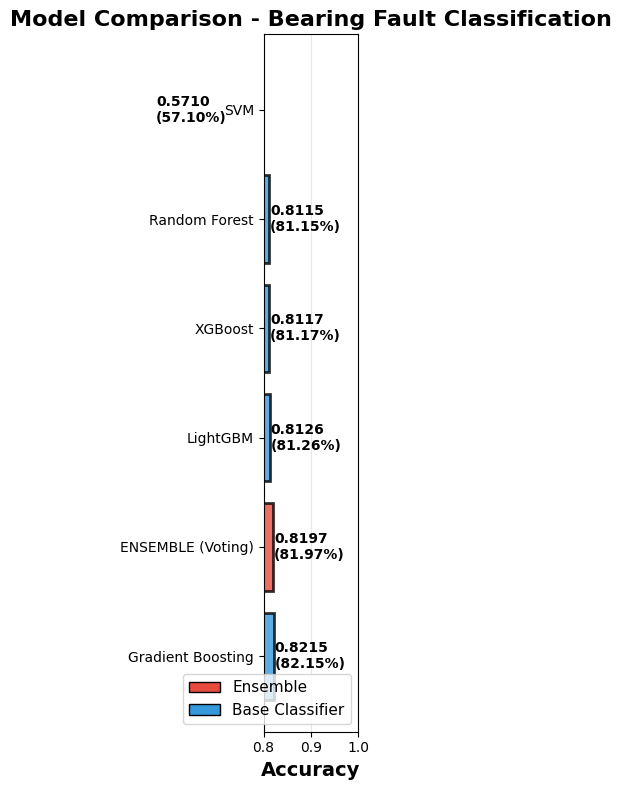

  ✓ Saved: ensemble_model_comparison.png

2. Creating confusion matrix...


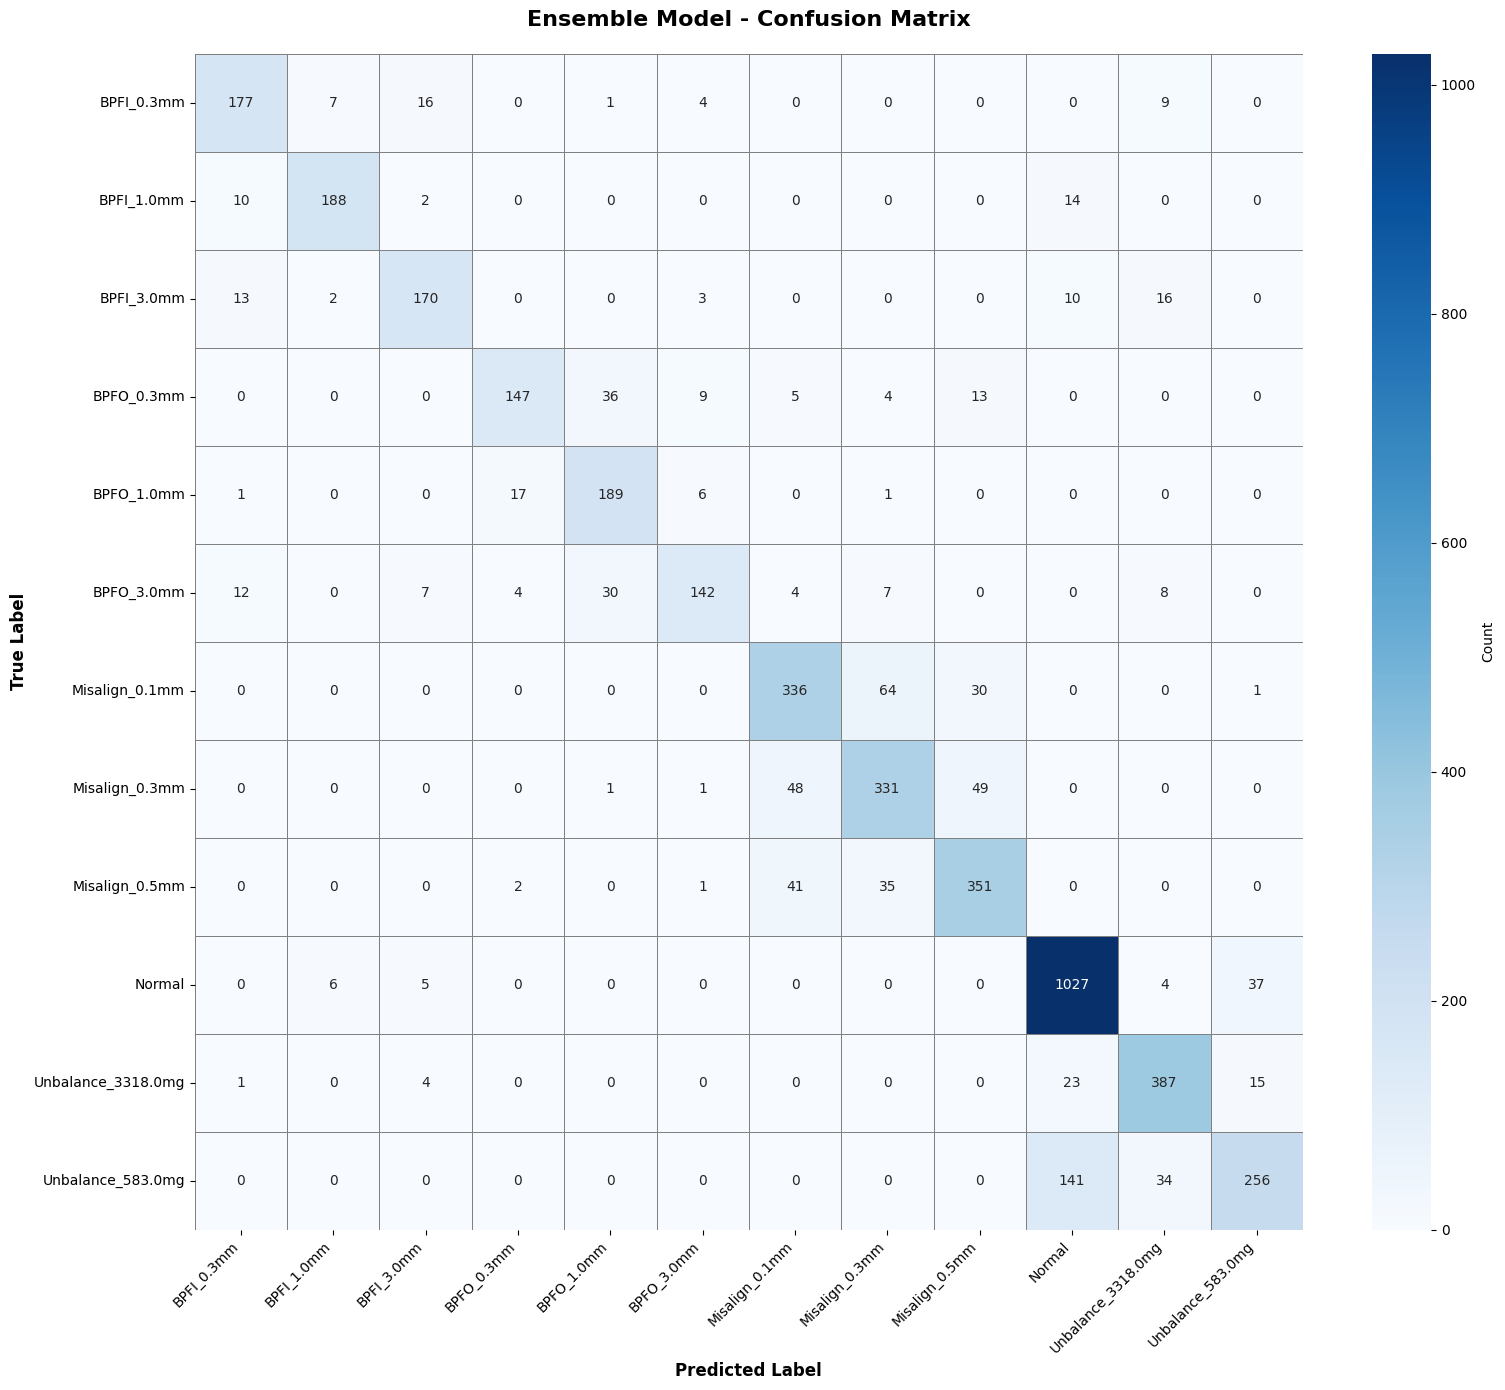

  ✓ Saved: ensemble_confusion_matrix.png

3. Creating normalized confusion matrix...


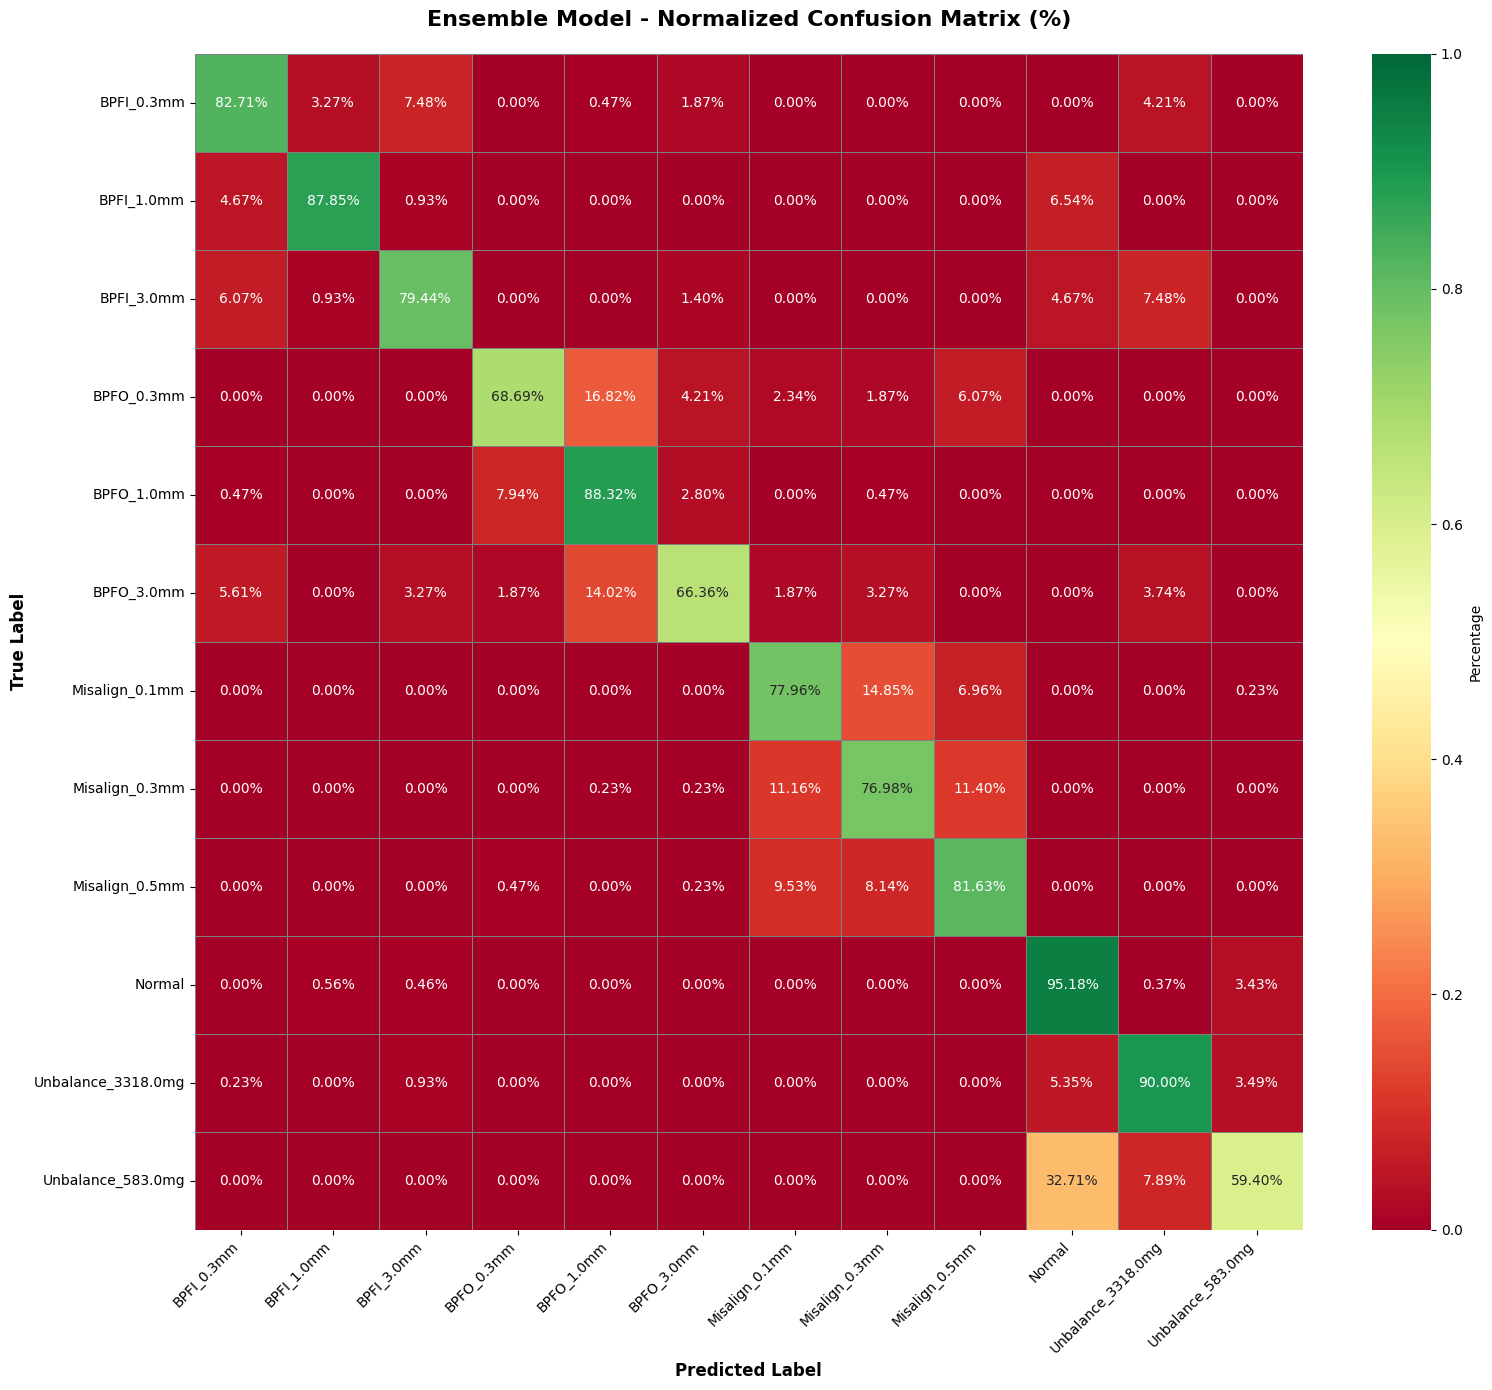

  ✓ Saved: ensemble_confusion_matrix_normalized.png

4. Creating per-class performance chart...


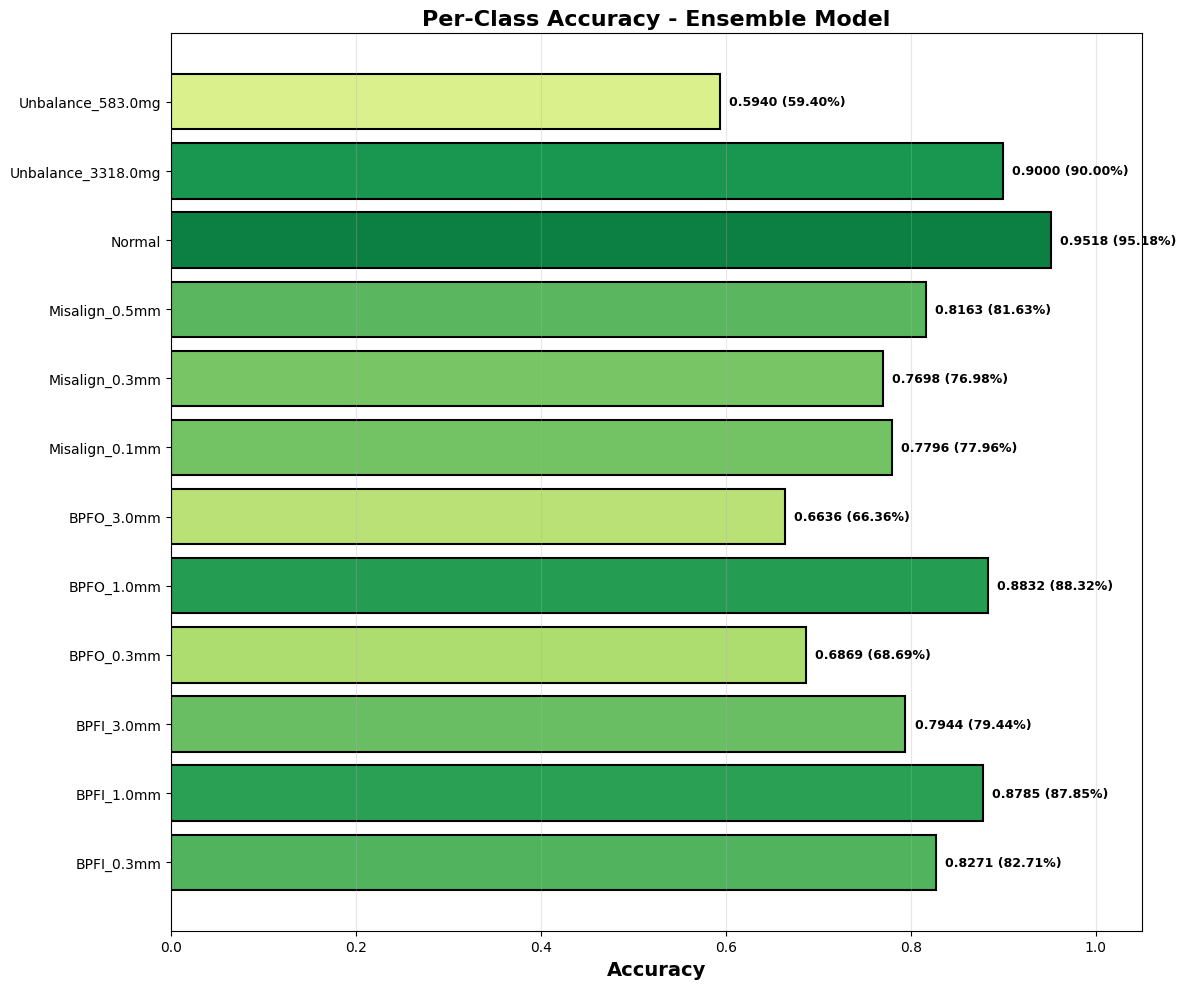

  ✓ Saved: ensemble_per_class_accuracy.png

5. Creating prediction confidence distribution...


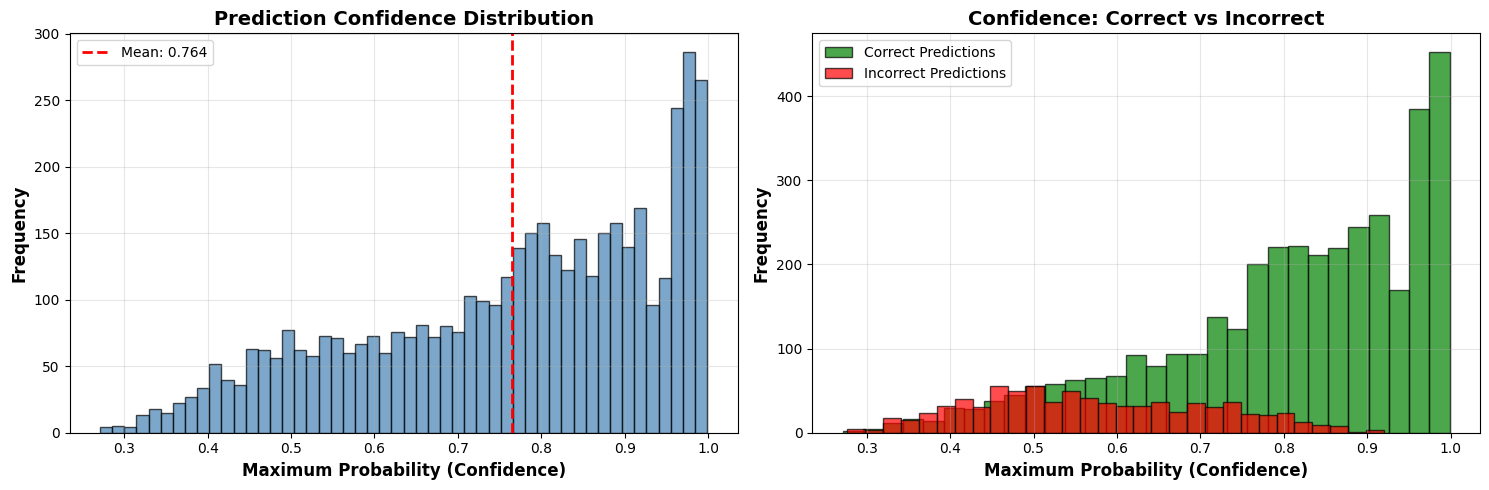

  ✓ Saved: ensemble_confidence_distribution.png

✓ All visualizations generated successfully!


In [15]:
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# 1. Model Comparison Bar Chart
print("\n1. Creating model comparison chart...")
fig, ax = plt.subplots(figsize=(12, 8))

colors = ['#e74c3c' if row['Type'] == 'Ensemble' else '#3498db' for _, row in comparison_df.iterrows()]
bars = ax.barh(comparison_df['Model'], comparison_df['Accuracy'], color=colors, 
               alpha=0.8, edgecolor='black', linewidth=2)

ax.set_xlabel('Accuracy', fontsize=14, fontweight='bold')
ax.set_title('Model Comparison - Bearing Fault Classification', fontsize=16, fontweight='bold')
ax.set_xlim([0.8, 1.0])
ax.grid(axis='x', alpha=0.3)

# Add value labels
for bar, acc in zip(bars, comparison_df['Accuracy']):
    ax.text(acc + 0.002, bar.get_y() + bar.get_height()/2,
            f'{acc:.4f}\n({acc*100:.2f}%)',
            va='center', ha='left', fontweight='bold', fontsize=10)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', edgecolor='black', label='Ensemble'),
    Patch(facecolor='#3498db', edgecolor='black', label='Base Classifier')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=11)

plt.tight_layout()
plt.savefig('ensemble_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Saved: ensemble_model_comparison.png")

# 2. Confusion Matrix
print("\n2. Creating confusion matrix...")
cm = confusion_matrix(y_test, y_pred_ensemble)

plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'},
            linewidths=0.5, linecolor='gray')
plt.title('Ensemble Model - Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('ensemble_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Saved: ensemble_confusion_matrix.png")

# 3. Normalized Confusion Matrix (Percentages)
print("\n3. Creating normalized confusion matrix...")
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16, 14))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Percentage'},
            linewidths=0.5, linecolor='gray',
            vmin=0, vmax=1)
plt.title('Ensemble Model - Normalized Confusion Matrix (%)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('ensemble_confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Saved: ensemble_confusion_matrix_normalized.png")

# 4. Per-Class Performance
print("\n4. Creating per-class performance chart...")
class_accuracies = []
class_names = []

for i, class_name in enumerate(label_encoder.classes_):
    class_mask = y_test == i
    if np.sum(class_mask) > 0:
        class_acc = accuracy_score(y_test[class_mask], y_pred_ensemble[class_mask])
        class_accuracies.append(class_acc)
        class_names.append(class_name)

fig, ax = plt.subplots(figsize=(12, 10))
colors_gradient = plt.cm.RdYlGn(np.array(class_accuracies))
bars = ax.barh(class_names, class_accuracies, color=colors_gradient, 
               edgecolor='black', linewidth=1.5)

ax.set_xlabel('Accuracy', fontsize=14, fontweight='bold')
ax.set_title('Per-Class Accuracy - Ensemble Model', fontsize=16, fontweight='bold')
ax.set_xlim([0, 1.05])
ax.grid(axis='x', alpha=0.3)

# Add value labels
for bar, acc in zip(bars, class_accuracies):
    ax.text(acc + 0.01, bar.get_y() + bar.get_height()/2,
            f'{acc:.4f} ({acc*100:.2f}%)',
            va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('ensemble_per_class_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Saved: ensemble_per_class_accuracy.png")

# 5. Prediction Confidence Distribution
print("\n5. Creating prediction confidence distribution...")
max_probabilities = np.max(y_pred_proba_ensemble, axis=1)
correct_predictions = y_pred_ensemble == y_test

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall confidence distribution
axes[0].hist(max_probabilities, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(np.mean(max_probabilities), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {np.mean(max_probabilities):.3f}')
axes[0].set_xlabel('Maximum Probability (Confidence)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Confidence: Correct vs Incorrect
axes[1].hist(max_probabilities[correct_predictions], bins=30, alpha=0.7, 
             label='Correct Predictions', color='green', edgecolor='black')
axes[1].hist(max_probabilities[~correct_predictions], bins=30, alpha=0.7, 
             label='Incorrect Predictions', color='red', edgecolor='black')
axes[1].set_xlabel('Maximum Probability (Confidence)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Confidence: Correct vs Incorrect', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('ensemble_confidence_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("  ✓ Saved: ensemble_confidence_distribution.png")

print("\n✓ All visualizations generated successfully!")

In [16]:
print("\n" + "="*80)
print("TESTING ENSEMBLE MODEL ON SAMPLE DATA")
print("="*80)

# Test on some random samples from test set
print("\n1. Testing on Random Samples from Test Set:")
print("-"*80)

np.random.seed(42)
sample_indices = np.random.choice(len(X_test_scaled), size=10, replace=False)

for idx in sample_indices:
    # Get sample
    sample_features = X_test_scaled[idx:idx+1]
    true_label = y_test[idx]
    true_class = label_encoder.classes_[true_label]
    
    # Predict
    pred_label = ensemble_model.predict(sample_features)[0]
    pred_class = label_encoder.classes_[pred_label]
    pred_proba = ensemble_model.predict_proba(sample_features)[0]
    confidence = np.max(pred_proba)
    
    # Display result
    status = "✓ CORRECT" if pred_label == true_label else "✗ INCORRECT"
    print(f"\nSample #{idx}:")
    print(f"  True Label:      {true_class}")
    print(f"  Predicted:       {pred_class}")
    print(f"  Confidence:      {confidence:.4f} ({confidence*100:.2f}%)")
    print(f"  Status:          {status}")
    
    # Show top 3 predictions
    top_3_indices = np.argsort(pred_proba)[-3:][::-1]
    print(f"  Top 3 predictions:")
    for i, top_idx in enumerate(top_3_indices, 1):
        print(f"    {i}. {label_encoder.classes_[top_idx]:30s} - {pred_proba[top_idx]:.4f} ({pred_proba[top_idx]*100:.2f}%)")

# Test on specific fault types
print("\n" + "="*80)
print("2. Testing on Specific Fault Types:")
print("-"*80)

fault_types_to_test = ['Normal', 'BPFI_0.3mm', 'BPFO_3.0mm', 'Misalign_0.5mm', 'Unbalance_3318.0mg']

for fault_type in fault_types_to_test:
    if fault_type in label_encoder.classes_:
        fault_idx = np.where(label_encoder.classes_ == fault_type)[0][0]
        fault_samples = X_test_scaled[y_test == fault_idx]
        
        if len(fault_samples) > 0:
            # Predict on all samples of this fault type
            predictions = ensemble_model.predict(fault_samples)
            probabilities = ensemble_model.predict_proba(fault_samples)
            
            # Calculate accuracy for this fault type
            accuracy = np.mean(predictions == fault_idx)
            avg_confidence = np.mean(np.max(probabilities, axis=1))
            
            print(f"\n{fault_type}:")
            print(f"  Samples:         {len(fault_samples)}")
            print(f"  Accuracy:        {accuracy:.4f} ({accuracy*100:.2f}%)")
            print(f"  Avg Confidence:  {avg_confidence:.4f} ({avg_confidence*100:.2f}%)")
            
            # Show misclassifications if any
            misclassified = predictions != fault_idx
            if np.any(misclassified):
                print(f"  Misclassifications:")
                misclass_preds = predictions[misclassified]
                for pred in np.unique(misclass_preds):
                    count = np.sum(misclass_preds == pred)
                    print(f"    → {label_encoder.classes_[pred]}: {count} times")

print("\n✓ Testing complete!")


TESTING ENSEMBLE MODEL ON SAMPLE DATA

1. Testing on Random Samples from Test Set:
--------------------------------------------------------------------------------

Sample #1212:
  True Label:      BPFI_3.0mm
  Predicted:       BPFI_3.0mm
  Confidence:      0.9796 (97.96%)
  Status:          ✓ CORRECT
  Top 3 predictions:
    1. BPFI_3.0mm                     - 0.9796 (97.96%)
    2. BPFO_3.0mm                     - 0.0067 (0.67%)
    3. BPFI_0.3mm                     - 0.0065 (0.65%)

Sample #2812:
  True Label:      BPFI_0.3mm
  Predicted:       BPFI_0.3mm
  Confidence:      0.9324 (93.24%)
  Status:          ✓ CORRECT
  Top 3 predictions:
    1. BPFI_0.3mm                     - 0.9324 (93.24%)
    2. BPFI_3.0mm                     - 0.0401 (4.01%)
    3. BPFO_3.0mm                     - 0.0178 (1.78%)

Sample #805:
  True Label:      Misalign_0.1mm
  Predicted:       Misalign_0.1mm
  Confidence:      0.3850 (38.50%)
  Status:          ✓ CORRECT
  Top 3 predictions:
    1. Misalign_

In [17]:
print("\n" + "="*80)
print("SAVING ENSEMBLE MODEL")
print("="*80)

import joblib

# Save the ensemble model
joblib.dump(ensemble_model, 'ensemble_bearing_fault_classifier.pkl')
print("✓ Ensemble model saved: ensemble_bearing_fault_classifier.pkl")

# Save preprocessing objects
joblib.dump(scaler, 'ensemble_feature_scaler.pkl')
print("✓ Feature scaler saved: ensemble_feature_scaler.pkl")

joblib.dump(label_encoder, 'ensemble_label_encoder.pkl')
print("✓ Label encoder saved: ensemble_label_encoder.pkl")

# Save feature column names
joblib.dump(feature_cols, 'ensemble_feature_columns.pkl')
print("✓ Feature columns saved: ensemble_feature_columns.pkl")

# Save model metadata
model_metadata = {
    'model_type': 'Voting Ensemble',
    'base_classifiers': ['Random Forest', 'XGBoost', 'LightGBM', 'SVM', 'Gradient Boosting'],
    'num_features': len(feature_cols),
    'num_classes': len(label_encoder.classes_),
    'classes': label_encoder.classes_.tolist(),
    'test_accuracy': ensemble_accuracy,
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

import json
with open('ensemble_model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)
print("✓ Model metadata saved: ensemble_model_metadata.json")

print("\n" + "="*80)
print("ALL FILES SAVED SUCCESSFULLY!")
print("="*80)
print("\nSaved files:")
print("  • ensemble_bearing_fault_classifier.pkl")
print("  • ensemble_feature_scaler.pkl")
print("  • ensemble_label_encoder.pkl")
print("  • ensemble_feature_columns.pkl")
print("  • ensemble_model_metadata.json")
print("  • ensemble_model_comparison.png")
print("  • ensemble_confusion_matrix.png")
print("  • ensemble_confusion_matrix_normalized.png")
print("  • ensemble_per_class_accuracy.png")
print("  • ensemble_confidence_distribution.png")


SAVING ENSEMBLE MODEL
✓ Ensemble model saved: ensemble_bearing_fault_classifier.pkl
✓ Feature scaler saved: ensemble_feature_scaler.pkl
✓ Label encoder saved: ensemble_label_encoder.pkl
✓ Feature columns saved: ensemble_feature_columns.pkl
✓ Model metadata saved: ensemble_model_metadata.json

ALL FILES SAVED SUCCESSFULLY!

Saved files:
  • ensemble_bearing_fault_classifier.pkl
  • ensemble_feature_scaler.pkl
  • ensemble_label_encoder.pkl
  • ensemble_feature_columns.pkl
  • ensemble_model_metadata.json
  • ensemble_model_comparison.png
  • ensemble_confusion_matrix.png
  • ensemble_confusion_matrix_normalized.png
  • ensemble_per_class_accuracy.png
  • ensemble_confidence_distribution.png
